# 03 - XGBoost Model: Predicting Global Radiation (glorad)

### Objective  
This notebook trains an XGBoost regression model to predict daily global radiation (glorad) using available weather features: rainfall, maximum temperature (maxtp), and minimum temperature (mintp).  

The model aims to serve as the first stage of a two-stage forecasting pipeline, providing an estimated radiation value that can be used to predict daily solar energy generation in the next stage.  

This approach addresses a key challenge in the Irish context — the unavailability of glorad forecasts — by attempting to model glorad from weather features that are available both historically and as forecasts.


### Import and Prepare Data

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from itertools import product


In [100]:
# Load Cleaned Data and view head
df = pd.read_csv("../../Cleaned Data/Cleaned_National_Irish_Weather_Solar_2024.csv")

df.head()

,date,rain,maxtp,mintp,cbl,glorad,solargen
0,1/01/2024,11.93,10.57,3.03,981.90,64.44,471.02
1,2/01/2024,5.77,10.22,6.53,973.32,125.44,601.80
2,3/01/2024,2.10,9.21,5.46,981.98,210.22,1286.11
3,4/01/2024,1.18,8.17,2.52,991.51,309.00,2788.48
4,5/01/2024,0.36,8.18,2.28,1001.11,314.89,2966.48


### Train/Test Split


In [95]:
# Select features and target
X = df[['rain', 'maxtp', 'mintp']]
y = df['glorad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Fit XGBoost with initial parameters

In [96]:
model = xgb.XGBRegressor(
    max_depth=2,
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    reg_alpha=0.5,
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [97]:
# Predict on both train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate Train
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"Train: R²: {r2_train:.3f} | RMSE: {rmse_train:.2f} | MAE: {mae_train:.2f}")

# Evaluate Test
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Test : R²: {r2_test:.3f} | RMSE: {rmse_test:.2f} | MAE: {mae_test:.2f}")



Train: R²: 0.802 | RMSE: 305.54 | MAE: 240.06
Test : R²: 0.454 | RMSE: 443.99 | MAE: 337.24


### Grid Search for Best L1 and L2 parameters

In [98]:
lambdas = [0, 0.1, 1, 2, 5]
alphas = [0, 0.1, 0.5, 1, 2]

results_reg = []

for reg_lambda in lambdas:
    for reg_alpha in alphas:
        model = xgb.XGBRegressor(
            max_depth=2,
            learning_rate=0.1,
            n_estimators=100,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            random_state=42
        )

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        results_reg.append({
            'reg_lambda': reg_lambda,
            'reg_alpha': reg_alpha,
            'r2_train': r2_train,
            'r2_test': r2_test
        })


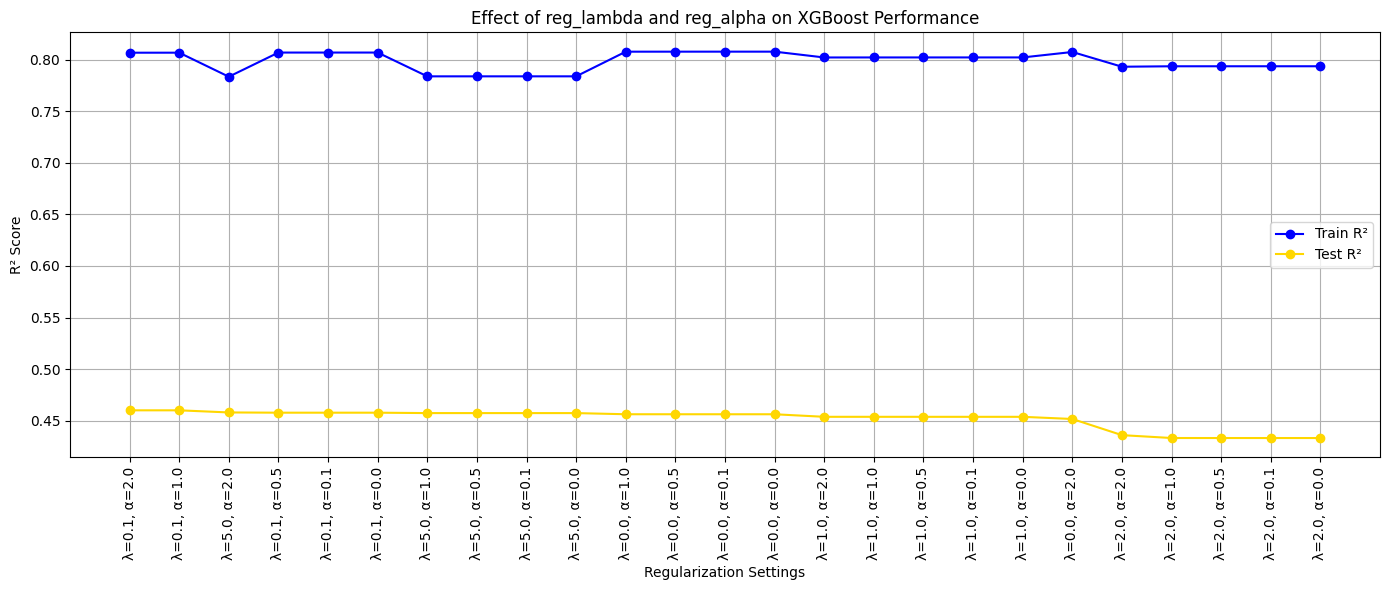

In [99]:
# Plot Results

results_reg_df = pd.DataFrame(results_reg)

# Label for plot
results_reg_df['label'] = results_reg_df.apply(
    lambda row: f"λ={row['reg_lambda']}, α={row['reg_alpha']}", axis=1
)

# Sort for easier reading
results_reg_df = results_reg_df.sort_values(by='r2_test', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_reg_df['label'], results_reg_df['r2_train'], label='Train R²', color='blue', marker='o')
plt.plot(results_reg_df['label'], results_reg_df['r2_test'], label='Test R²', color='gold', marker='o')
plt.xticks(rotation=90)
plt.xlabel("Regularization Settings")
plt.ylabel("R² Score")
plt.title("Effect of reg_lambda and reg_alpha on XGBoost Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
